In [259]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from pandas.plotting import scatter_matrix
%matplotlib inline

df = pd.read_csv("../Data/diabetes.csv")

df.info(), df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


(None,
    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
 0            6      148             72             35        0  33.6   
 1            1       85             66             29        0  26.6   
 2            8      183             64              0        0  23.3   
 3            1       89             66             23       94  28.1   
 4            0      137             40             35      168  43.1   
 
    DiabetesPedigreeFunction  Age  Outcome  
 0                     0.627   50        1  
 1                     0.351   31        0  
 2                     0.672   32        1  
 3                     0.167   21        0  
 4                     2.288   33        1  )

***Check for missing values***

In [260]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

***Check for duplicates***

In [261]:
df.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
763    False
764    False
765    False
766    False
767    False
Length: 768, dtype: bool

***Description of our data(statistics)***

In [262]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


***Identify columns with zeros***
**(Zeros might indicate missing values)**

In [263]:
zeros = (df == 0).sum()
zeros
# From the above columns like Glucose,blood pressure,skin thickness,insulin and BMI contain zero values which are likely to be missing values.

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

***Replace zeros with Nan***

In [264]:
columns_with_zeros = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
df[columns_with_zeros] = df[columns_with_zeros].replace(0, np.nan)
# Check for null again
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

***Handle missing values using imputation techniques such as median or mean.***

In [265]:
# Impute with median as it is robust to outliers
for col in ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]: df[col].fillna(df[col].median(), inplace=True)

df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

***Check for outliers***

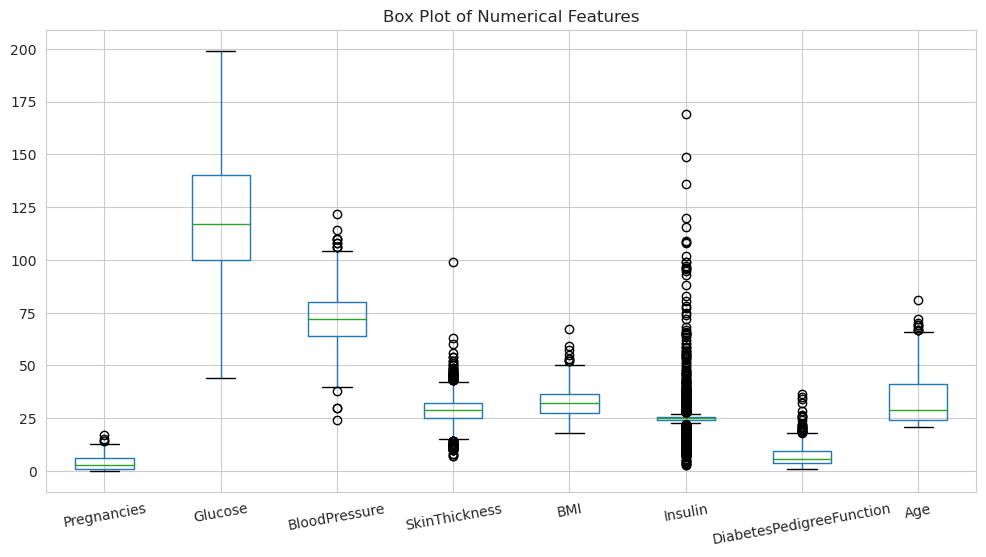

In [266]:
sns.set_style("whitegrid")

df_scaled = df.copy()
df_scaled["DiabetesPedigreeFunction"] *=15 # Scale up this feature
df_scaled["Insulin"] /=5 # Scale down this feature
plt.figure(figsize=(12, 6))
df_scaled.boxplot(column=["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "BMI", "Insulin", "DiabetesPedigreeFunction", "Age"])
plt.xticks(rotation=10)
plt.title("Box Plot of Numerical Features")
plt.show()
# The box plot reveals some potential outliers

***Confirm outliers using Interquartile Range method***

In [267]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers.shape[0]

# Check number of outliers in each numerical column
outliers_count = {col: detect_outliers_iqr(df, col) for col in ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "BMI", "DiabetesPedigreeFunction", "Age"]}
outliers_count

{'Pregnancies': 4,
 'Glucose': 0,
 'BloodPressure': 14,
 'SkinThickness': 87,
 'BMI': 8,
 'DiabetesPedigreeFunction': 29,
 'Age': 9}

***Cap outlier values preserve data while reducing extremes***
**(Remove insulin as it has too many missing values)**

In [268]:
# Function to cap outliers using IQR bounds
def cap_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[column] = np.where(data[column] < lower_bound, lower_bound, data[column])
    data[column] = np.where(data[column] > upper_bound, upper_bound, data[column])

# Apply capping on selected columns
for col in ["BloodPressure", "SkinThickness", "BMI", "DiabetesPedigreeFunction", "Age"]:
    cap_outliers(df, col)

df.drop(columns=["Insulin"], inplace=True)
# Verify if extreme values are capped
df.describe()


,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.358073,28.866536,32.393359,0.458914,33.199870,0.348958
std,3.369578,30.438286,11.697097,7.442353,6.667471,0.285596,11.628404,0.476951
min,0.000000,44.000000,40.000000,14.500000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,104.000000,42.500000,50.250000,1.200000,66.500000,1.000000


***Visualizations***

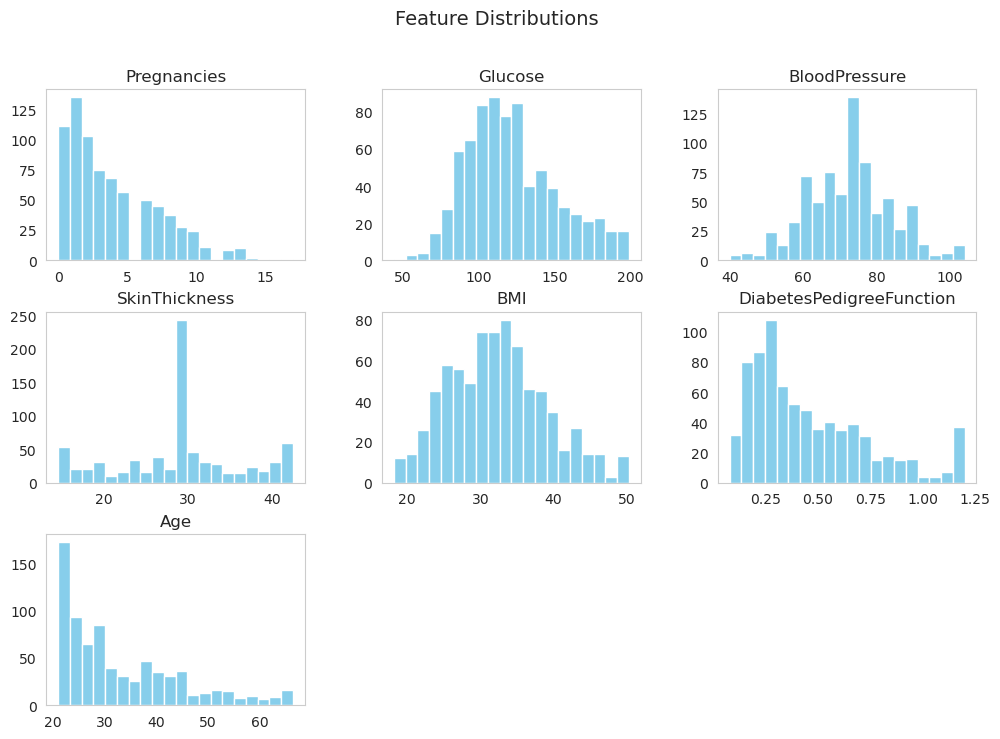

In [269]:
# Plot histograms for numerical features
df[numerical_columns].hist(figsize=(12, 8), bins=20, grid=False, color="skyblue")
plt.suptitle("Feature Distributions", fontsize=14)
plt.show()


***Correlatin maxtrix***

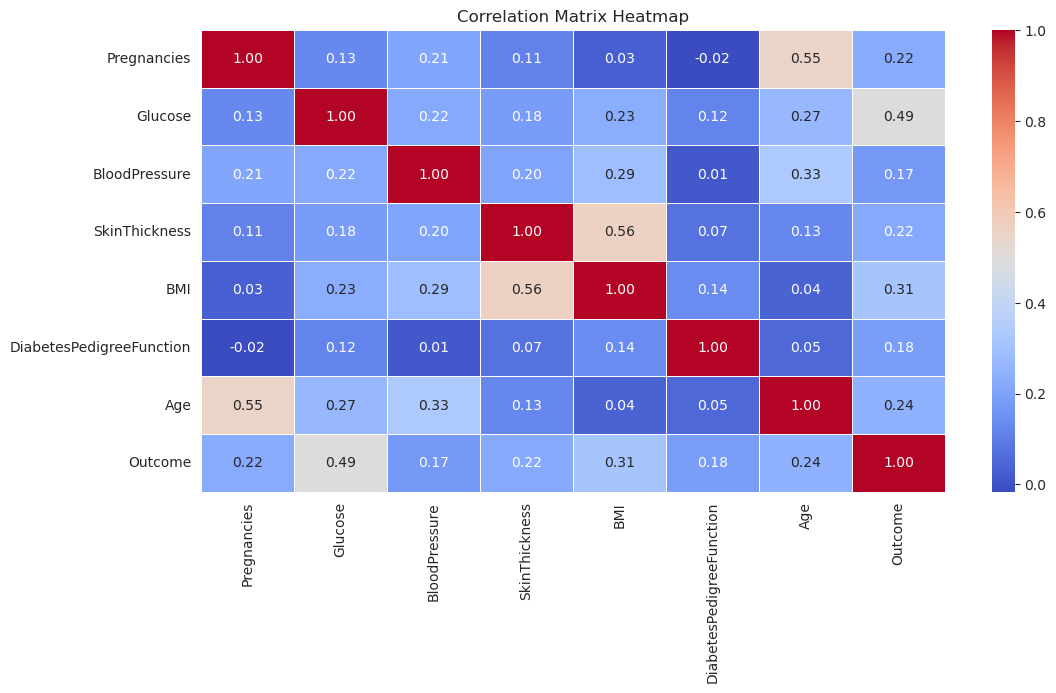

In [270]:
# Compute correlation matrix
correlation_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()


***Count plot for the outcome***

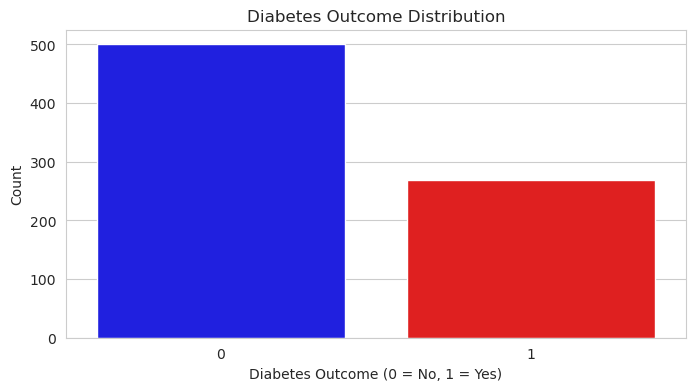

In [271]:
plt.figure(figsize=(8, 4))
sns.countplot(
    x="Outcome", 
    data=df, 
    hue="Outcome",  # Set Outcome as hue
    palette={0: "blue", 1: "red"},  # Assign colors to each class
    legend=False  # Hide duplicate legend
)
plt.xlabel(f'Diabetes Outcome (0 = No, 1 = Yes)')
plt.ylabel("Count")
plt.title("Diabetes Outcome Distribution")
plt.show()
# Most people in the data do not have diabetes

***How Glucos Differ Between Diabetics and Non-Diabetics***

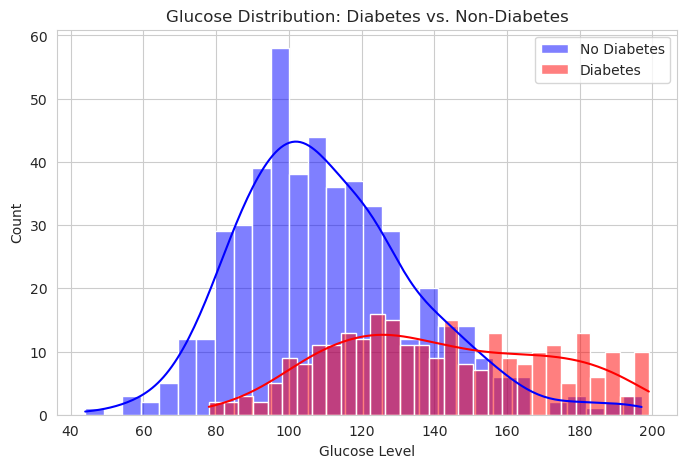

In [272]:
plt.figure(figsize=(8,5))
sns.histplot(df[df["Outcome"] == 0]["Glucose"], color="blue", label="No Diabetes", kde=True, bins=30)
sns.histplot(df[df["Outcome"] == 1]["Glucose"], color="red", label="Diabetes", kde=True, bins=30)
plt.xlabel("Glucose Level")
plt.ylabel("Count")
plt.title("Glucose Distribution: Diabetes vs. Non-Diabetes")
plt.legend()
plt.show()
# It is seen that diabetics tend to have higher glucose levels.


***Age Distribution Between Diabetics and Non-Diabetics***


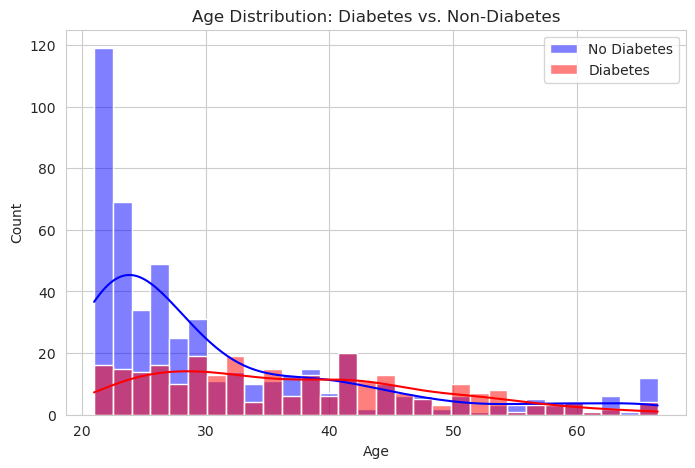

In [273]:
plt.figure(figsize=(8,5))
sns.histplot(df[df["Outcome"] == 0]["Age"], color="blue", label="No Diabetes", kde=True, bins=30)
sns.histplot(df[df["Outcome"] == 1]["Age"], color="red", label="Diabetes", kde=True, bins=30)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution: Diabetes vs. Non-Diabetes")
plt.legend()
plt.show()

# Diabetes is more common in older individuals.
# Younger individuals (under 30) have a lower risk, but it still exists.

***BMI between Diabetics and Non-Diabetics***

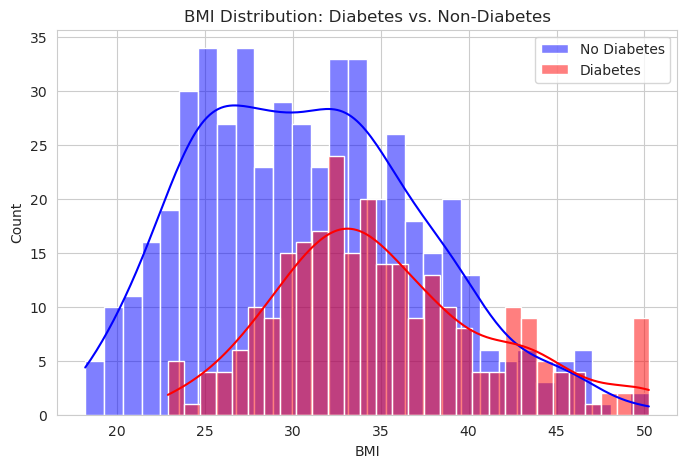

In [274]:
plt.figure(figsize=(8,5))
sns.histplot(df[df["Outcome"] == 0]["BMI"], color="blue", label="No Diabetes", kde=True, bins=30)
sns.histplot(df[df["Outcome"] == 1]["BMI"], color="red", label="Diabetes", kde=True, bins=30)
plt.xlabel("BMI")
plt.ylabel("Count")
plt.title("BMI Distribution: Diabetes vs. Non-Diabetes")
plt.legend()
plt.show()
# Higher BMI values increase diabetes risk.

***Splitting data to features and scaling***

In [275]:
scaler = StandardScaler()

# Splitting data into features and target

X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state = 42, stratify = y)
# Feature Scaling
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X.head(), y.head()


(   Pregnancies  Glucose  BloodPressure  SkinThickness   BMI  \
 0            6    148.0           72.0           35.0  33.6   
 1            1     85.0           66.0           29.0  26.6   
 2            8    183.0           64.0           29.0  23.3   
 3            1     89.0           66.0           23.0  28.1   
 4            0    137.0           40.0           35.0  43.1   
 
    DiabetesPedigreeFunction   Age  
 0                     0.627  50.0  
 1                     0.351  31.0  
 2                     0.672  32.0  
 3                     0.167  21.0  
 4                     1.200  33.0  ,
 0    1
 1    0
 2    1
 3    0
 4    1
 Name: Outcome, dtype: int64)

***K-Nearest Neighbor***

In [276]:
test_scores = []
train_scores = []

for i in range(1, 15):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train, y_train)
    
    train_scores.append(knn.score(X_train, y_train))
    test_scores.append(knn.score(X_test, y_test))

In [277]:
# Check train scores
train_scores

[1.0,
 0.82421875,
 0.8515625,
 0.791015625,
 0.82421875,
 0.791015625,
 0.8046875,
 0.798828125,
 0.802734375,
 0.794921875,
 0.787109375,
 0.783203125,
 0.783203125,
 0.783203125]

In [278]:
# Check test scores
test_scores

[0.6875,
 0.71875,
 0.73828125,
 0.73828125,
 0.73828125,
 0.7578125,
 0.71875,
 0.7265625,
 0.76171875,
 0.74609375,
 0.7734375,
 0.7421875,
 0.7578125,
 0.73828125]

***Max test and train scores***

In [279]:
# TRAIN SCORE
max_train_score = max(train_scores)
train_scores_ind = [i for i, v in enumerate(train_scores) if v == max_train_score]
print('Max train score {} % and k = {}'.format(max_train_score*100, list(map(lambda x: x+1, train_scores_ind))))

Max train score 100.0 % and k = [1]


In [280]:
# TEST SCORE
max_test_score = max(test_scores)
test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score]
print('Max test score {} % and k = {}'.format(max_test_score*100, list(map(lambda x: x+1, test_scores_ind))))

Max test score 77.34375 % and k = [11]


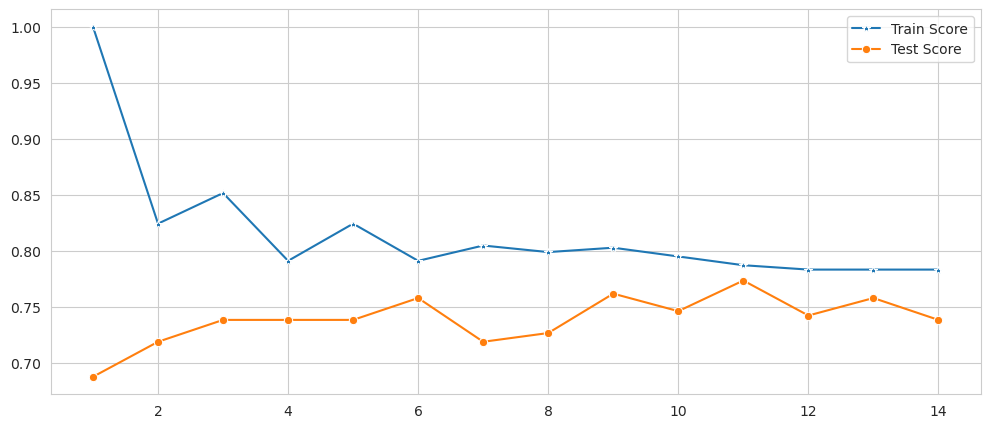

In [281]:
plt.figure(figsize=(12,5))
p = sns.lineplot(x=range(1,15), y=train_scores, marker='*', label='Train Score')
p = sns.lineplot(x=range(1,15), y=test_scores, marker='o', label='Test Score')
# Graph checking best training and testing score

In [282]:
knn = KNeighborsClassifier(11)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)
# Use k=11 to build a model

0.7734375

***Confusion Matrix***

Text(0.5, 23.52222222222222, 'Predicted label')

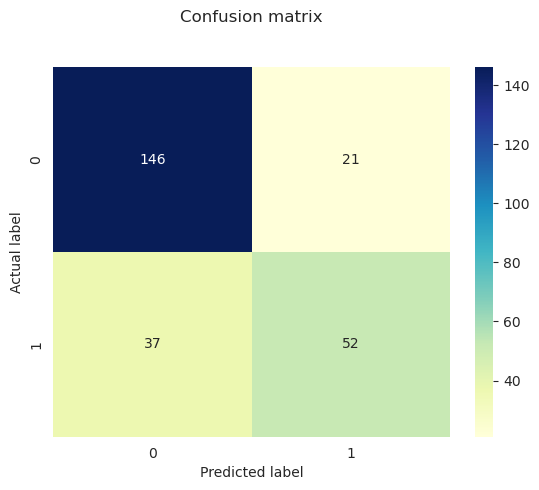

In [283]:
y_pred = knn.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = "YlGnBu", fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
# Evaluates performance of the model

In [284]:
#classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       167
           1       0.71      0.58      0.64        89

    accuracy                           0.77       256
   macro avg       0.76      0.73      0.74       256
weighted avg       0.77      0.77      0.77       256



***Hyperparameter tuning for KNN using GridSearchCV***

In [285]:
param_grid = {
    'n_neighbors':np.arange(1,10),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn,param_grid, cv=5, scoring='accuracy')
knn_cv.fit(X,y)

print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters:" + str(knn_cv.best_params_))

Best Score:0.7656990068754774
Best Parameters:{'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'uniform'}


***Testing other models***

In [286]:
model_results = {}
model_results["KNeigborsClassifier"] = accuracy_score(y_test, y_pred)


**Logical Regression**

In [287]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
model_results["Logistic Regression"] = accuracy_score(y_test, y_pred_lr)

**Random Forest Classifier**

In [288]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split = 5, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
model_results["Random Forest"] = accuracy_score(y_test, y_pred_rf)

***Display Accuracy Scores***

In [289]:
print("\nModel Performance Comparison:")
for model, acc in model_results.items():
    print(f"{model}: {acc:.4f}")


Model Performance Comparison:
KNeigborsClassifier: 0.7734
Logistic Regression: 0.7305
Random Forest: 0.7305


***Best Model***

In [290]:
best_model = max(model_results, key=model_results.get)
print(f"\nBest Model: {best_model}")


Best Model: KNeigborsClassifier
